In [1]:
%load_ext autoreload
%autoreload 2

# Analyzing the trained model

In [2]:
# import os; os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".99"

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from typing import Any, Callable, Sequence, Union
import numpy as np

import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

import jax
from jax import lax, random, numpy as jnp
from flax.core import freeze, unfreeze, FrozenDict
from flax import linen as nn
from flax import struct
from flax.training import train_state
from flax.training import orbax_utils

import optax
import orbax.checkpoint

from clu import metrics
from ml_collections import ConfigDict

from einops import reduce, rearrange
import wandb
from iqadatasets.datasets import *
from fxlayers.layers import *
from fxlayers.layers import GaussianLayerGamma, GaborLayerLogSigma_, FreqGaussianGamma, OrientGaussianGamma
from fxlayers.initializers import *
from JaxPlayground.utils.constraints import *
from JaxPlayground.utils.wandb import *

2024-06-26 11:09:41.901512: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 11:09:50.400270: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-26 11:10:11.028456: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-06-26 11:10:11.029252: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: mlui01.ific.uv.es
2024-06-26 11:10:11.029639: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: mlui01.ific.uv.es
2024-06-26 11:10:11.029822: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagno

In [4]:
# jax.config.update("jax_debug_nans", False)

In [5]:
import matplotlib.pyplot as plt

In [6]:
id = "znsqf8nr" # FinalModelRestricted

In [7]:
api = wandb.Api()
prev_run = api.run(f"jorgvt/PerceptNet_v15/{id}")

In [8]:
config = ConfigDict(prev_run.config["_fields"])

In [9]:
for file in prev_run.files():
    file.download(root=prev_run.dir, replace=True)

## Define the model we're going to use

> It's going to be a very simple model just for demonstration purposes.

In [10]:
#| exporti
class ChromaFreqOrientGaussianGamma(nn.Module):
    """(1D) Gaussian interaction between gamma_fuencies and orientations optimizing gamma = 1/sigma instead of sigma."""
    use_bias: bool = False
    strides: int = 1
    padding: str = "SAME"
    bias_init: Callable = nn.initializers.zeros_init()
    n_scales: Sequence[int] = jnp.array([4, 2, 2], dtype=jnp.int32)
    n_orientations: Sequence[int] = jnp.array([8, 8, 8], dtype=jnp.int32)

    @nn.compact
    def __call__(self,
                 inputs,
                 fmean,
                 theta_mean,
                 **kwargs,
                 ):

        gamma_f_a = self.param("gamma_f_a",
                             k_array(1/0.4, arr=jnp.array([2.,4.,8.,16.])),
                             (self.n_scales[0],))
        gamma_theta_a = self.param("gamma_theta_a",
                                 nn.initializers.ones_init(),
                                #  (self.n_orientations[0],))
                                 (8,))

        gamma_f_t = self.param("gamma_f_t",
                             k_array(1/0.4, arr=jnp.array([3.,6.])),
                             (self.n_scales[1],))
        gamma_theta_t = self.param("gamma_theta_t",
                                 nn.initializers.ones_init(),
                                #  (self.n_orientations[1],))
                                 (8,))
        
        gamma_f_d = self.param("gamma_f_d",
                             k_array(1/0.4, arr=jnp.array([3.,6.])),
                             (self.n_scales[2],))
        gamma_theta_d = self.param("gamma_theta_d",
                                 nn.initializers.ones_init(),
                                #  (self.n_orientations[2],))
                                 (8,))

        H_cc = self.param("H_cc",
                          nn.initializers.ones_init(),
                          (3,3))

        if self.use_bias: bias = self.param("bias",
                                            self.bias_init,
                                            (len(fmean),))
        else: bias = 0.
        # n_groups = inputs.shape[-1] // len(fmean)

        ## Repeat gammas
        gamma_f = jnp.concatenate([jnp.tile(f, reps=len(t)) for f,t in zip([gamma_f_a, gamma_f_t, gamma_f_d], [gamma_theta_a, gamma_theta_t, gamma_theta_d])])
        gamma_f = jnp.tile(gamma_f, reps=2)
        gamma_theta = jnp.concatenate([jnp.tile(t, reps=len(f)) for f,t in zip([gamma_f_a, gamma_f_t, gamma_f_d], [gamma_theta_a, gamma_theta_t, gamma_theta_d])])
        gamma_theta = jnp.tile(gamma_theta, reps=2)

        ## Repeating
        cc = jnp.array([0,1,2])
        cc = jnp.repeat(cc, repeats=jnp.array([64,32,32]), total_repeat_length=len(fmean))

        kernel = jax.vmap(self.gaussian, in_axes=(None,None,0,0,0,0,None,0,None,None), out_axes=1)(fmean, theta_mean, fmean, theta_mean, gamma_f, gamma_theta, cc, cc, H_cc, 1)
        kernel = kernel[None,None,:,:]

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]; had_batch = False
        else: had_batch = True
        outputs = lax.conv_general_dilated(
                jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
                jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
                (self.strides, self.strides),
                self.padding)
        ## Move the channels back to the last dim
        outputs = jnp.transpose(outputs, (0,2,3,1))
        if not had_batch: outputs = outputs[0]
        return outputs + bias

    @staticmethod
    def gaussian(f, theta, fmean, theta_mean, gamma_f, gamma_theta, c_1, c_2, H_cc, A=1):
        return H_cc[c_1,c_2]*A*jnp.exp(-((gamma_f**2)*(f-fmean)**2)/(2))*jnp.exp(-((gamma_theta**2)*(theta-theta_mean)**2)/(2))

In [11]:
class GDNSpatioChromaFreqOrient(nn.Module):
    """Generalized Divisive Normalization."""
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    # inputs_star: float = 1.
    # outputs_star: Union[None, float] = None
    fs: int = 1
    apply_independently: bool = False
    bias_init: Callable = nn.initializers.ones_init()
    alpha: float = 2.
    epsilon: float = 1/2 # Exponential of the denominator
    eps: float = 1e-6 # Numerical stability in the denominator

    @nn.compact
    def __call__(self,
                 inputs,
                 fmean,
                 theta_mean,
                 train=False,
                 ):
        b, h, w, c = inputs.shape
        bias = self.param("bias",
                          #equal_to(inputs_star/10),
                          self.bias_init,
                          (c,))
        # is_initialized = self.has_variable("batch_stats", "inputs_star")
        # inputs_star = self.variable("batch_stats", "inputs_star", lambda x: jnp.ones(x)*self.inputs_star, (len(self.inputs_star),))
        # inputs_star_ = jnp.ones_like(inputs)*inputs_star.value
        GL = GaussianLayerGamma(features=c, kernel_size=self.kernel_size, strides=self.strides, padding="VALID", fs=self.fs, xmean=self.kernel_size/self.fs/2, ymean=self.kernel_size/self.fs/2, normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, use_bias=False, feature_group_count=c)
        FOG = ChromaFreqOrientGaussianGamma()
        outputs = GL(pad_same_from_kernel_size(inputs, kernel_size=self.kernel_size, mode=self.padding)**self.alpha, train=train)#/(self.kernel_size**2)
        outputs = FOG(outputs, fmean=fmean, theta_mean=theta_mean)

        ## Coef
        # coef = GL(inputs_star_**self.alpha, train=train)#/(self.kernel_size**2)
        # coef = FG(coef, fmean=fmean)
        # coef = rearrange(coef, "b h w (phase theta f) -> b h w (phase f theta)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)
        # coef = OG(coef, theta_mean=theta_mean) + bias
        # coef = rearrange(coef, "b h w (phase f theta) -> b h w (phase theta f)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)
        # coef = jnp.clip(coef+bias, a_min=1e-5)**self.epsilon
        # # coef = inputs_star.value * coef
        # if self.outputs_star is not None: coef = coef/inputs_star.value*self.outputs_star

        # if is_initialized and train:
        #     inputs_star.value = (inputs_star.value + jnp.quantile(jnp.abs(inputs), q=0.95, axis=(0,1,2)))/2
        # return coef * inputs / (jnp.clip(denom+bias, a_min=1e-5)**self.epsilon + self.eps)
        return inputs / (jnp.clip(outputs+bias, a_min=1e-5)**self.epsilon + self.eps)

In [12]:
class GaborLayerGammaHumanLike_(nn.Module):
    """Parametric Gabor layer with particular initialization."""
    n_scales: Sequence[int] # [A, T, D]
    n_orientations: Sequence[int] # [A, T, D]

    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    feature_group_count: int = 1

    use_bias: bool = False
    xmean: float = 0.5
    ymean: float = 0.5
    fs: float = 1 # Sampling frequency
    phase = jnp.array([0., jnp.pi/2.])

    normalize_prob: bool = True
    normalize_energy: bool = False
    zero_mean: bool = False
    train_A: bool = False

    @nn.compact
    def __call__(self,
                 inputs,
                 train=False,
                 return_freq=False,
                 return_theta=False,
                 ):
        total_scales = jnp.sum(jnp.array(self.n_scales))
        total_orientations = jnp.sum(jnp.array(self.n_orientations))
        features = jnp.sum(jnp.array([s*o*len(self.phase) for s, o in zip(self.n_scales, self.n_orientations)]))

        is_initialized = self.has_variable("precalc_filter", "kernel")
        precalc_filters = self.variable("precalc_filter",
                                        "kernel",
                                        jnp.zeros,
                                        (self.kernel_size, self.kernel_size, inputs.shape[-1], features))
        freq_a = self.param("freq_a",
                           freq_scales_init(n_scales=self.n_scales[0], fs=self.fs),
                           (self.n_scales[0],))
        gammax_a = self.param("gammax_a",
                           k_array(k=0.4, arr=1/(freq_a**0.8)),
                           (self.n_scales[0],))
        gammay_a = self.param("gammay_a",
                            equal_to(gammax_a*0.8),
                            (self.n_scales[0],))
        theta_a = self.param("theta_a",
                           linspace(start=0, stop=jnp.pi, num=self.n_orientations[0]),
                           (self.n_orientations[0],))
        sigma_theta_a = self.param("sigma_theta_a",
                                  equal_to(theta_a),
                                  (self.n_orientations[0],))

        freq_t = self.param("freq_t",
                           freq_scales_init(n_scales=self.n_scales[1], fs=self.fs),
                           (self.n_scales[1],))
        gammax_t = self.param("gammax_t",
                           k_array(k=0.4, arr=1/(freq_t**0.8)),
                           (self.n_scales[1],))
        gammay_t = self.param("gammay_t",
                            equal_to(gammax_t*0.8),
                            (self.n_scales[1],))
        theta_t = self.param("theta_t",
                           linspace(start=0, stop=jnp.pi, num=self.n_orientations[1]),
                           (self.n_orientations[1],))
        sigma_theta_t = self.param("sigma_theta_t",
                                  equal_to(theta_t),
                                  (self.n_orientations[1],))

        freq_d = self.param("freq_d",
                           freq_scales_init(n_scales=self.n_scales[2], fs=self.fs),
                           (self.n_scales[2],))
        gammax_d = self.param("gammax_d",
                           k_array(k=0.4, arr=1/(freq_d**0.8)),
                           (self.n_scales[2],))
        gammay_d = self.param("gammay_d",
                            equal_to(gammax_d*0.8),
                            (self.n_scales[2],))
        theta_d = self.param("theta_d",
                           linspace(start=0, stop=jnp.pi, num=self.n_orientations[2]),
                           (self.n_orientations[2],))
        sigma_theta_d = self.param("sigma_theta_d",
                                  equal_to(theta_d),
                                  (self.n_orientations[2],))

        # A = self.param("A",
        #                nn.initializers.ones_init(),
        #                (inputs.shape[-1], features)) if self.train_A else jnp.ones(shape=(inputs.shape[-1], features))
        A = self.param("A",
                       nn.initializers.ones_init(),
                       (inputs.shape[-1], 128))
        if self.use_bias: bias = self.param("bias",
                                            self.bias_init,
                                            (features,))
        else: bias = 0.

        if is_initialized and not train: 
            kernel = precalc_filters.value
        elif is_initialized and train: 
            x, y = self.generate_dominion()
            ## A
            kernel_a = jax.vmap(self.gabor, in_axes=(None,None,None,None,0,0,0,None,None,None,None,None,None,None), out_axes=0)
            kernel_a = jax.vmap(kernel_a, in_axes=(None,None,None,None,None,None,None,0,0,None,None,None,None,None), out_axes=0)
            kernel_a = jax.vmap(kernel_a, in_axes=(None,None,None,None,None,None,None,None,None,0,None,None,None,None), out_axes=0)(x, y, self.xmean, self.ymean, gammax_a, gammay_a, freq_a, theta_a, sigma_theta_a, self.phase, 1, self.normalize_prob, self.normalize_energy, self.zero_mean)
            kernel_a = rearrange(kernel_a, "phases rots fs_sigmas kx ky -> kx ky (phases rots fs_sigmas)")
            kernel_a = repeat(kernel_a, "kx ky c_out -> kx ky c_in c_out", c_in=inputs.shape[-1], c_out=kernel_a.shape[-1])

            ## T
            kernel_t = jax.vmap(self.gabor, in_axes=(None,None,None,None,0,0,0,None,None,None,None,None,None,None), out_axes=0)
            kernel_t = jax.vmap(kernel_t, in_axes=(None,None,None,None,None,None,None,0,0,None,None,None,None,None), out_axes=0)
            kernel_t = jax.vmap(kernel_t, in_axes=(None,None,None,None,None,None,None,None,None,0,None,None,None,None), out_axes=0)(x, y, self.xmean, self.ymean, gammax_t, gammay_t, freq_t, theta_t, sigma_theta_t, self.phase, 1, self.normalize_prob, self.normalize_energy, self.zero_mean)
            kernel_t = rearrange(kernel_t, "phases rots fs_sigmas kx ky -> kx ky (phases rots fs_sigmas)")
            kernel_t = repeat(kernel_t, "kx ky c_out -> kx ky c_in c_out", c_in=inputs.shape[-1], c_out=kernel_t.shape[-1])

            ## D
            kernel_d = jax.vmap(self.gabor, in_axes=(None,None,None,None,0,0,0,None,None,None,None,None,None,None), out_axes=0)
            kernel_d = jax.vmap(kernel_d, in_axes=(None,None,None,None,None,None,None,0,0,None,None,None,None,None), out_axes=0)
            kernel_d = jax.vmap(kernel_d, in_axes=(None,None,None,None,None,None,None,None,None,0,None,None,None,None), out_axes=0)(x, y, self.xmean, self.ymean, gammax_d, gammay_d, freq_d, theta_d, sigma_theta_d, self.phase, 1, self.normalize_prob, self.normalize_energy, self.zero_mean)
            kernel_d = rearrange(kernel_d, "phases rots fs_sigmas kx ky -> kx ky (phases rots fs_sigmas)")
            kernel_d = repeat(kernel_d, "kx ky c_out -> kx ky c_in c_out", c_in=inputs.shape[-1], c_out=kernel_d.shape[-1])

            ## Concat all of them
            kernel = jnp.concatenate([kernel_a, kernel_t, kernel_d], axis=-1)
            kernel = kernel * A[None,None,:,:]
            precalc_filters.value = kernel
        else:
            kernel = precalc_filters.value

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]; had_batch = False
        else: had_batch = True
        outputs = lax.conv(jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
               jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
               (self.strides, self.strides),
               self.padding)
        ## Move the channels back to the last dim
        outputs = jnp.transpose(outputs, (0,2,3,1))
        fmean = jnp.concatenate([jnp.tile(f, reps=len(t)) for f,t in zip([freq_a, freq_t, freq_d], [theta_a, theta_t, theta_d])])
        fmean = jnp.tile(fmean, reps=2)
        theta_mean = jnp.concatenate([jnp.tile(t, reps=len(f)) for f,t in zip([freq_a, freq_t, freq_d], [theta_a, theta_t, theta_d])])
        theta_mean = jnp.tile(theta_mean, reps=2)

        if not had_batch: outputs = outputs[0]
        if return_freq and return_theta:
            return outputs + bias, fmean, theta_mean 
        elif return_freq and not return_theta:
            return outputs + bias, fmean
        elif not return_freq and return_theta:
            return outputs + bias, theta_mean
        else:
            return outputs + bias

    @staticmethod
    def gabor(x, y, xmean, ymean, gammax, gammay, freq, theta, sigma_theta, phase, A=1, normalize_prob=True, normalize_energy=False, zero_mean=False):
        x, y = x-xmean, y-ymean
        ## Obtain the normalization coeficient
        gamma_vector = jnp.array([gammax, gammay])
        inv_cov_matrix = jnp.diag(gamma_vector)**2
        # det_cov_matrix = 1/jnp.linalg.det(cov_matrix)
        # # A_norm = 1/(2*jnp.pi*jnp.sqrt(det_cov_matrix)) if normalize_prob else 1.
        # A_norm = jnp.where(normalize_prob, 1/(2*jnp.pi*jnp.sqrt(det_cov_matrix)), 1.)
        A_norm = 1.
        
        ## Rotate the sinusoid
        rotation_matrix = jnp.array([[jnp.cos(sigma_theta), -jnp.sin(sigma_theta)],
                                     [jnp.sin(sigma_theta), jnp.cos(sigma_theta)]])
        rotated_covariance = rotation_matrix @ inv_cov_matrix @ jnp.transpose(rotation_matrix)
        x_r_1 = rotated_covariance[0,0] * x + rotated_covariance[0,1] * y
        y_r_1 = rotated_covariance[1,0] * x + rotated_covariance[1,1] * y
        distance = x * x_r_1 + y * y_r_1
        g = A_norm*jnp.exp(-distance/2) * jnp.cos(2*jnp.pi*freq*(x*jnp.cos(theta)+y*jnp.sin(theta)) + phase)
        g = jnp.where(zero_mean, g - g.mean(), g)
        E_norm = jnp.where(normalize_energy, jnp.sqrt(jnp.sum(g**2)), 1.)
        return A*g/E_norm

    def return_kernel(self, params, c_in=3):
        x, y = self.generate_dominion()
        sigmax, sigmay = jnp.exp(params["sigmax"]), jnp.exp(params["sigmay"])
        kernel = jax.vmap(self.gabor, in_axes=(None,None,None,None,0,0,None,None,None,None,None,None,None), out_axes=0)
        kernel = jax.vmap(kernel, in_axes=(None,None,None,None,None,None,0,None,None,None,None,None,None), out_axes=0)
        kernel = jax.vmap(kernel, in_axes=(None,None,None,None,None,None,None,0,0,0,None,None,None), out_axes=0)(x, y, self.xmean, self.ymean, params["sigmax"], params["sigmay"], params["freq"], params["theta"], params["sigma_theta"], self.phase, 1, self.normalize_prob, self.normalize_energy)
        # kernel = rearrange(kernel, "(c_in c_out) kx ky -> kx ky c_in c_out", c_in=inputs.shape[-1], c_out=self.features)
        kernel = rearrange(kernel, "rots fs sigmas kx ky -> kx ky (rots fs sigmas)")
        kernel = repeat(kernel, "kx ky c_out -> kx ky c_in c_out", c_in=c_in, c_out=kernel.shape[-1])
        return kernel
    
    def generate_dominion(self):
        return jnp.meshgrid(jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size), jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size))

In [13]:
class PerceptNet(nn.Module):
    """IQA model inspired by the visual system."""

    @nn.compact
    def __call__(self,
                 inputs, # Assuming fs = 128 (cpd)
                 **kwargs,
                 ):
        ## (Independent) Color equilibration (Gamma correction)
        ## Might need to be the same for each number
        ## bias = 0.1 / kernel = 0.5
        if config.USE_GAMMA: outputs = GDNGamma()(inputs)
        else: outputs = GDN(kernel_size=(1,1), apply_independently=True)(inputs)
        
        ## Color (ATD) Transformation
        outputs = nn.Conv(features=3, kernel_size=(1,1), use_bias=False, name="Color")(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        
        ## GDN Star A - T - D [Separated]
        outputs = GDN(kernel_size=(1,1), apply_independently=True)(outputs)

        ## Center Surround (DoG)
        ## Initialized so that 3 are positives and 3 are negatives and no interaction between channels is present
        outputs = pad_same_from_kernel_size(outputs, kernel_size=config.CS_KERNEL_SIZE, mode="symmetric")
        outputs = CenterSurroundLogSigmaK(features=3, kernel_size=config.CS_KERNEL_SIZE, fs=21, use_bias=False, padding="VALID")(outputs, **kwargs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))

        ## GDN per channel with mean substraction in T and D (Spatial Gaussian Kernel)
        ### fs = 32 / kernel_size = (11,11) -> 0.32 > 0.02 --> OK!
        ## TO-DO: - Spatial Gaussian Kernel (0.02 deg) -> fs = 64/2 & 0.02*64/2 = sigma (px) = 0.69
        outputs = GDNGaussian(kernel_size=config.GDNGAUSSIAN_KERNEL_SIZE, apply_independently=True, fs=32, padding="symmetric", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY)(outputs, **kwargs)

        ## GaborLayer per channel with GDN mixing only same-origin-channel information
        ### [Gaussian] sigma = 0.2 (deg) fs = 32 / kernel_size = (21,21) -> 21/32 = 0.66 --> OK!
        outputs = pad_same_from_kernel_size(outputs, kernel_size=config.GABOR_KERNEL_SIZE, mode="symmetric")
        # outputs, fmean, theta_mean = GaborLayerGamma_(n_scales=4+2+2, n_orientations=8*3, kernel_size=config.GABOR_KERNEL_SIZE, fs=32, xmean=config.GABOR_KERNEL_SIZE/32/2, ymean=config.GABOR_KERNEL_SIZE/32/2, strides=1, padding="VALID", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, zero_mean=config.ZERO_MEAN, use_bias=config.USE_BIAS, train_A=config.A_GABOR)(outputs, return_freq=True, return_theta=True, **kwargs)
        outputs, fmean, theta_mean = GaborLayerGammaHumanLike_(n_scales=[4,2,2], n_orientations=[8,8,8], kernel_size=config.GABOR_KERNEL_SIZE, fs=32, xmean=config.GABOR_KERNEL_SIZE/32/2, ymean=config.GABOR_KERNEL_SIZE/32/2, strides=1, padding="VALID", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, zero_mean=config.ZERO_MEAN, use_bias=config.USE_BIAS, train_A=config.A_GABOR)(outputs, return_freq=True, return_theta=True, **kwargs)
        
        ## Final GDN mixing Gabor information (?)
        outputs = GDNSpatioChromaFreqOrient(kernel_size=21, strides=1, padding="symmetric", fs=32, apply_independently=False)(outputs, fmean=fmean, theta_mean=theta_mean, **kwargs)

        return outputs

## Define the metrics with `clu`

In [14]:
@struct.dataclass
class Metrics(metrics.Collection):
    """Collection of metrics to be tracked during training."""
    loss: metrics.Average.from_output("loss")

By default, `TrainState` doesn't include metrics, but it's very easy to subclass it so that it does:

In [15]:
class TrainState(train_state.TrainState):
    metrics: Metrics
    state: FrozenDict

We'll define a function that initializes the `TrainState` from a module, a rng key and some optimizer:

In [16]:
def create_train_state(module, key, tx, input_shape):
    """Creates the initial `TrainState`."""
    variables = module.init(key, jnp.ones(input_shape))
    state, params = variables.pop('params')
    return TrainState.create(
        apply_fn=module.apply,
        params=params,
        state=state,
        tx=tx,
        metrics=Metrics.empty()
    )

## Defining the training step

> We want to write a function that takes the `TrainState` and a batch of data can performs an optimization step.

In [17]:
def pearson_correlation(vec1, vec2):
    vec1 = vec1.squeeze()
    vec2 = vec2.squeeze()
    vec1_mean = vec1.mean()
    vec2_mean = vec2.mean()
    num = vec1-vec1_mean
    num *= vec2-vec2_mean
    num = num.sum()
    denom = jnp.sqrt(jnp.sum((vec1-vec1_mean)**2))
    denom *= jnp.sqrt(jnp.sum((vec2-vec2_mean)**2))
    return num/denom

In [18]:
@jax.jit
def train_step(state, batch):
    """Train for a single step."""
    img, img_dist, mos = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred, updated_state = state.apply_fn({"params": params, **state.state}, img, mutable=list(state.state.keys()), train=True)
        img_dist_pred, updated_state = state.apply_fn({"params": params, **state.state}, img_dist, mutable=list(state.state.keys()), train=True)

        ## Calculate the distance
        dist = ((img_pred - img_dist_pred)**2).sum(axis=(1,2,3))**(1/2)
        
        ## Calculate pearson correlation
        return pearson_correlation(dist, mos), updated_state
    
    (loss, updated_state), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    metrics_updates = state.metrics.single_from_model_output(loss=loss)
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    state = state.replace(state=updated_state)
    return state

In their example, they don't calculate the metrics at the same time. I think it is kind of a waste because it means having to perform a new forward pass, but we'll follow as of now. Let's define a function to perform metric calculation:

In [19]:
@jax.jit
def compute_metrics(*, state, batch):
    """Obtaining the metrics for a given batch."""
    img, img_dist, mos = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred, updated_state = state.apply_fn({"params": params, **state.state}, img, mutable=list(state.state.keys()), train=False)
        img_dist_pred, updated_state = state.apply_fn({"params": params, **state.state}, img_dist, mutable=list(state.state.keys()), train=False)

        ## Calculate the distance
        dist = ((img_pred - img_dist_pred)**2).sum(axis=(1,2,3))**(1/2)
        
        ## Calculate pearson correlation
        return pearson_correlation(dist, mos)
    
    metrics_updates = state.metrics.single_from_model_output(loss=loss_fn(state.params))
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    return state

## Loading the weights

In [20]:
state = create_train_state(PerceptNet(), random.PRNGKey(config.SEED), optax.adam(config.LEARNING_RATE), input_shape=(1,384,512,3))
# state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))

In [21]:
import flax

In [22]:
def check_trainable(path):
    if not config.A_GDNSPATIOFREQORIENT:
        if ("GDNSpatioFreqOrient_0" in path) and ("A" in path):
            return True
    if "Color" in path:
        if not config.TRAIN_JH:
            return True
    if "CenterSurroundLogSigmaK_0" in path:
        if not config.TRAIN_CS:
            return True
    return False

In [23]:
trainable_tree = freeze(flax.traverse_util.path_aware_map(lambda path, v: "non_trainable" if check_trainable(path)  else "trainable", state.params))

In [24]:
optimizers = {
    "trainable": optax.adam(learning_rate=config.LEARNING_RATE),
    "non_trainable": optax.set_to_zero(),
}

In [25]:
tx = optax.multi_transform(optimizers, trainable_tree)

In [26]:
state = create_train_state(PerceptNet(), random.PRNGKey(config.SEED), tx, input_shape=(1,384,512,3))
# state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))

Instantiate the checkpointer to reload the already trained model:

In [27]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(state)

In [85]:
# state = orbax_checkpointer.restore(f"{prev_run.dir}/model-best", item=state)
state = orbax_checkpointer.restore(f"{prev_run.dir}/model-0", item=state)

In [86]:
param_count = sum(x.size for x in jax.tree_util.tree_leaves(state.params))
param_count

934

## Forward pass of the generated stimuli

In [87]:
from functools import partial

In [88]:
@jax.jit
def forward(state, inputs):
    return state.apply_fn({"params": state.params, **state.state}, inputs, train=False)

In [89]:
@jax.jit
def forward_intermediates(state, inputs):
    return state.apply_fn({"params": state.params, **state.state}, inputs, train=False, capture_intermediates=True)

In [90]:
import cv2

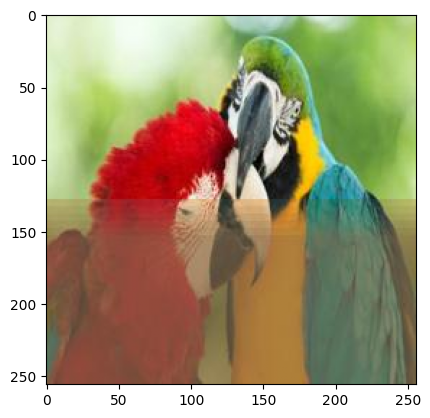

In [91]:
kk = cv2.imread("loritos_jesus_2.jpeg")
kk = cv2.cvtColor(kk, cv2.COLOR_BGR2RGB)/255.
plt.imshow(kk)
plt.show()
kk = kk[None,:]

In [92]:
%%time
outputs, extras = forward_intermediates(state, kk)
outputs.shape

CPU times: user 6.59 s, sys: 141 ms, total: 6.73 s
Wall time: 2.09 s


(1, 64, 64, 128)

## Checking the weights

In [93]:
state.params.keys()

frozen_dict_keys(['CenterSurroundLogSigmaK_0', 'Color', 'GDNGamma_0', 'GDNGaussian_0', 'GDNSpatioChromaFreqOrient_0', 'GDN_0', 'GaborLayerGammaHumanLike__0'])

### Gamma Correction

In [94]:
if config.USE_GAMMA: layer_name = "GDNGamma_0"
else: layer_name = "GDN_0"
state.params[layer_name]

FrozenDict({
    bias: array([0.1], dtype=float32),
    kernel: array([0.5], dtype=float32),
})

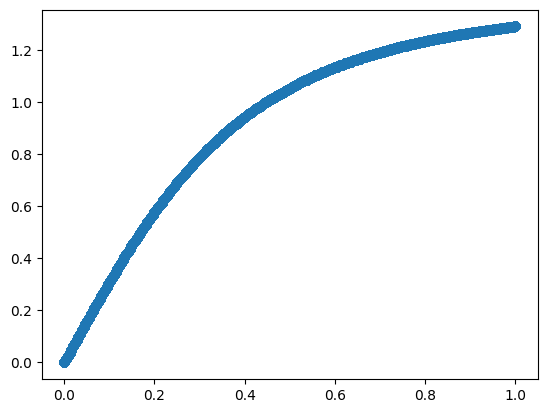

In [95]:
plt.scatter(kk.ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

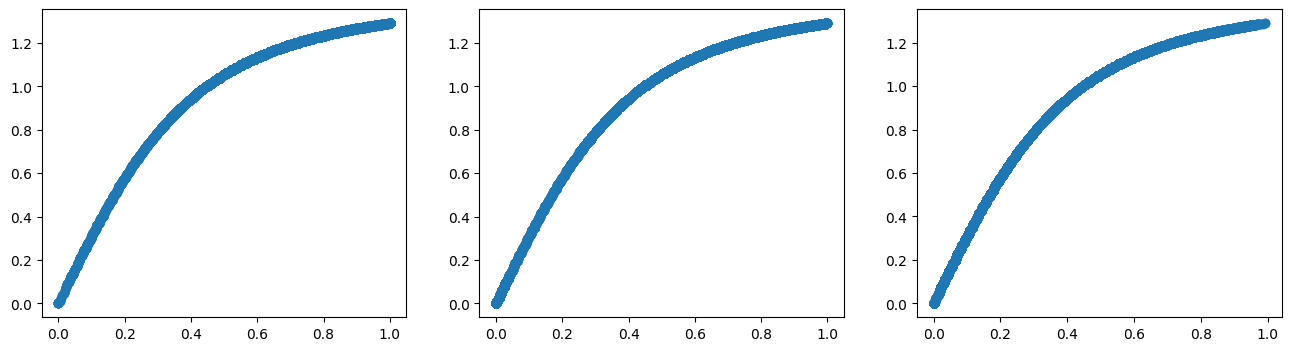

In [96]:
fig, axes = plt.subplots(1,3, figsize=(16,4))
for i, ax in enumerate(axes.ravel()):
    ax.scatter(kk[...,i].ravel(),
            extras["intermediates"][layer_name]["__call__"][0][...,i].ravel())
plt.show()

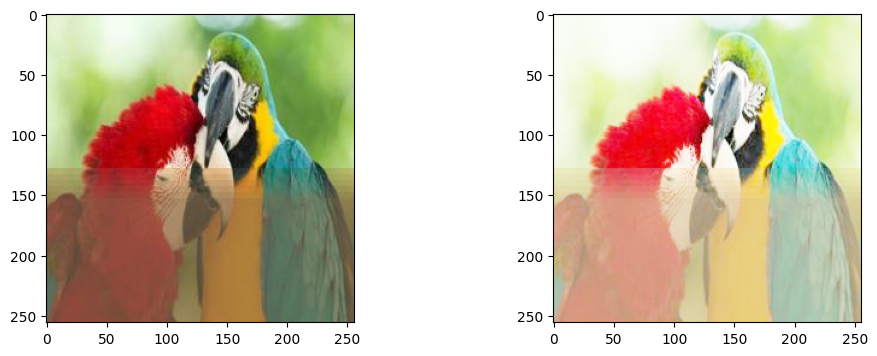

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].imshow(kk[0])
axes[1].imshow(extras["intermediates"][layer_name]["__call__"][0][0]/extras["intermediates"][layer_name]["__call__"][0][0].max())
plt.show()

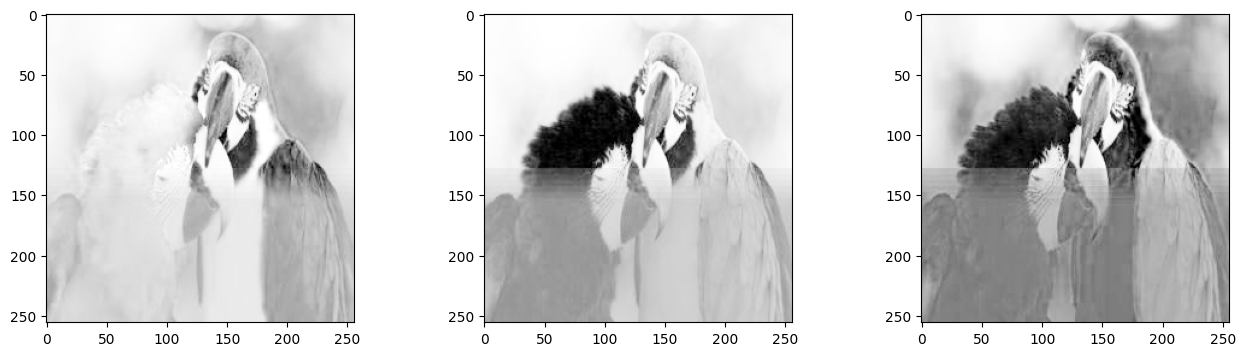

In [98]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))
for i, ax in enumerate(axes):
    ax.imshow(extras["intermediates"][layer_name]["__call__"][0][0,:,:,i], cmap="gray")
plt.show()

### J & H

In [99]:
if config.USE_GAMMA: prev_layer = "GDNGamma_0"
else: prev_layer = "GDN_0"
layer_name = "Color"

In [100]:
state.params["Color"]

FrozenDict({
    kernel: array([[[[ 0.2387781 ,  0.18420003,  0.08732468],
             [ 0.70840997, -0.3874116 ,  0.25237116],
             [ 0.09975313,  0.18525615, -0.37621233]]]], dtype=float32),
})

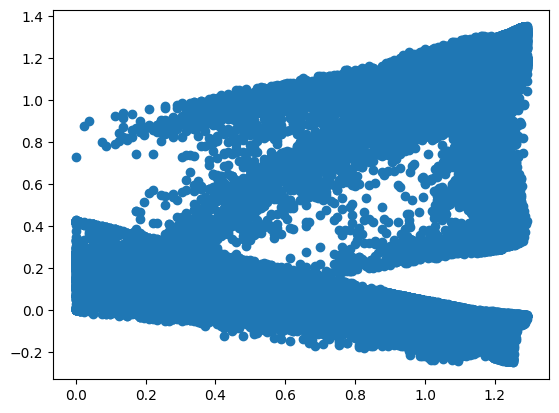

In [101]:
plt.scatter(extras["intermediates"][prev_layer]["__call__"][0].ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

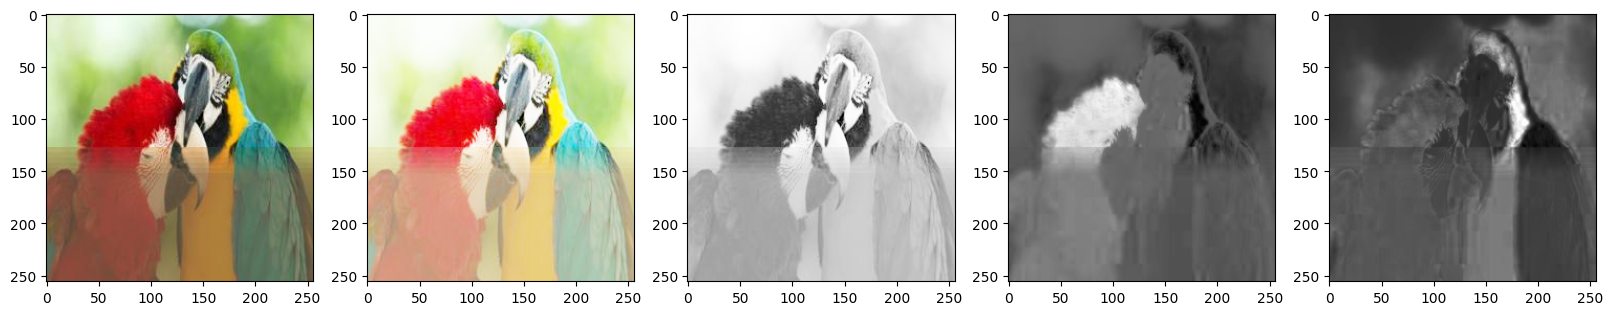

In [102]:
fig, axes = plt.subplots(1, 5, figsize=(20,4))
axes[0].imshow(kk[0])
axes[1].imshow(extras["intermediates"][prev_layer]["__call__"][0][0]/extras["intermediates"][prev_layer]["__call__"][0][0].max())
for i, ax in enumerate(axes[2:]):
    ax.imshow(extras["intermediates"][layer_name]["__call__"][0][0,:,:,i], cmap="gray")
plt.show()

### DN 1

In [147]:
# prev_layer = "Conv_0"
prev_layer = "Color"
if config.USE_GAMMA: layer_name = "GDN_0"
else: layer_name = "GDN_1"
state.params[layer_name]

FrozenDict({
    Conv_0: {
        bias: array([1., 1., 1.], dtype=float32),
        kernel: array([[[[0.33333334, 0.33333334, 0.33333334]]]], dtype=float32),
    },
})

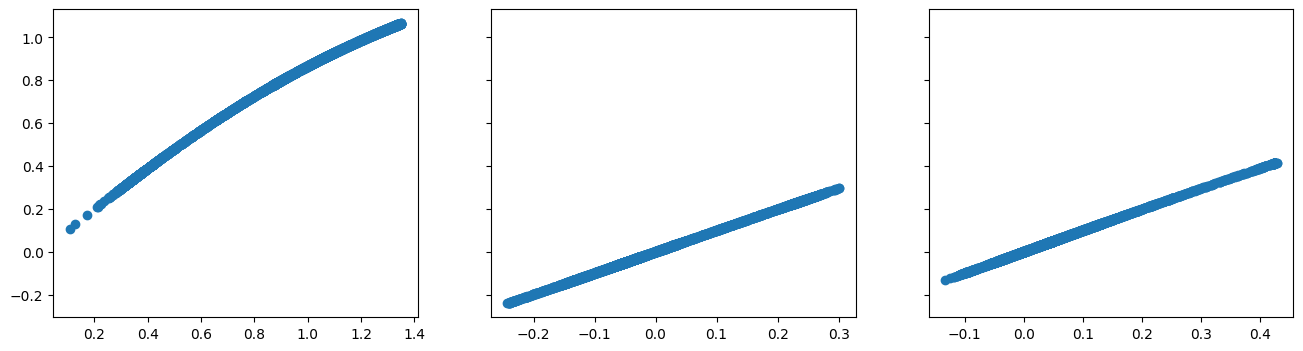

In [151]:
fig, axes = plt.subplots(1, 3, figsize=(16,4), sharey=True)
for i, ax in enumerate(axes):
    ax.scatter(nn.max_pool(extras["intermediates"][prev_layer]["__call__"][0], window_shape=(2,2), strides=(2,2))[0,:,:,i].ravel(),
               extras["intermediates"][layer_name]["__call__"][0][0,:,:,i].ravel())
plt.show()

### CSF (DoG)

In [106]:
prev_layer = "GDN_1"
layer_name = "CenterSurroundLogSigmaK_0"
state.params[layer_name]

FrozenDict({
    A: array([1., 0., 0., 0., 1., 0., 0., 0., 1.], dtype=float32),
    K: array([1.1, 1.1, 1.1, 5. , 5. , 5. , 5. , 5. , 5. ], dtype=float32),
    logsigma: array([-1.9 , -1.9 , -1.9 , -1.76, -1.76, -1.76, -1.76, -1.76, -1.76],
          dtype=float32),
})

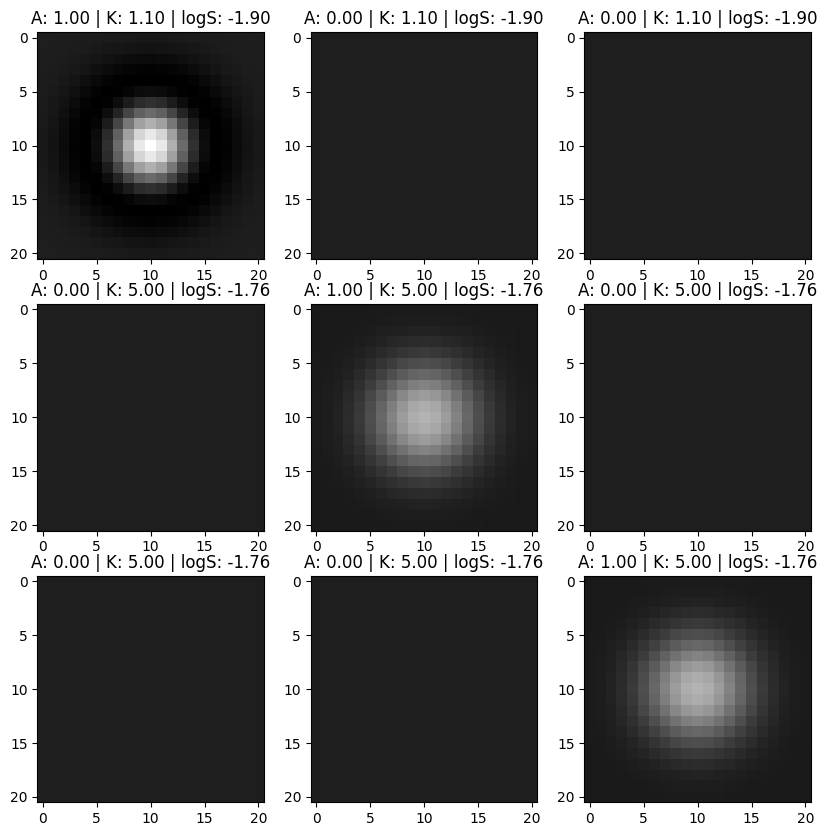

In [107]:
fig, axes = plt.subplots(3, 3, figsize=(10,10))
m, M = state.state["precalc_filter"][layer_name]["kernel"].min(), state.state["precalc_filter"][layer_name]["kernel"].max()
k = 0
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        ax.imshow(state.state["precalc_filter"][layer_name]["kernel"][:,:,i,j], vmin=m, vmax=M, cmap="gray")
        ax.set_title(f'A: {state.params[layer_name]["A"][k]:.2f} | K: {state.params[layer_name]["K"][k]:.2f} | logS: {state.params[layer_name]["logsigma"][k]:.2f}')
        k += 1
plt.show()

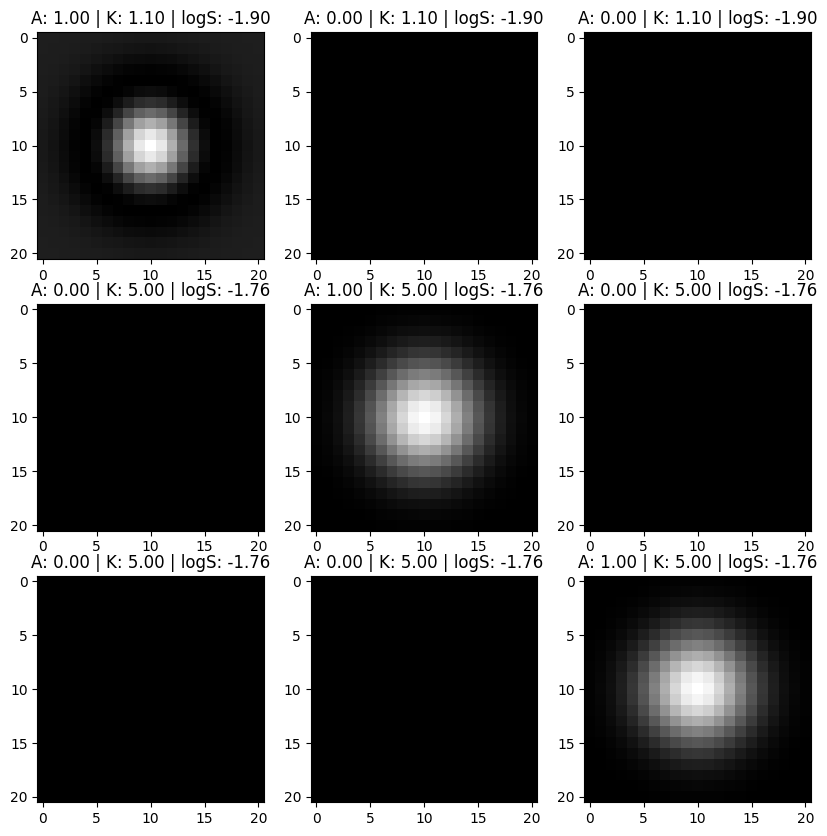

In [108]:
fig, axes = plt.subplots(3, 3, figsize=(10,10))
m, M = state.state["precalc_filter"][layer_name]["kernel"].min(), state.state["precalc_filter"][layer_name]["kernel"].max()
k = 0
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        ax.imshow(state.state["precalc_filter"][layer_name]["kernel"][:,:,i,j], cmap="gray")
        ax.set_title(f'A: {state.params[layer_name]["A"][k]:.2f} | K: {state.params[layer_name]["K"][k]:.2f} | logS: {state.params[layer_name]["logsigma"][k]:.2f}')
        k += 1
plt.show()

### DN (2)

In [109]:
prev_layer = "CenterSurroundLogSigmaK_0"
layer_name = "GDNGaussian_0"
state.params[layer_name]

FrozenDict({
    GaussianLayerGamma_0: {
        A: array([1., 1., 1.], dtype=float32),
        bias: array([0.1, 0.1, 0.1], dtype=float32),
        gamma: array([25., 25., 25.], dtype=float32),
    },
})

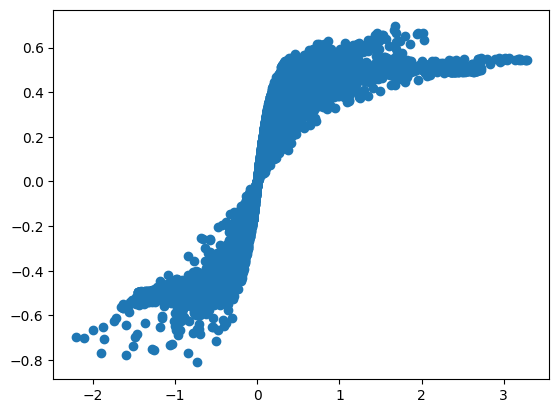

In [110]:
plt.scatter(nn.max_pool(extras["intermediates"][prev_layer]["__call__"][0], window_shape=(2,2), strides=(2,2)).ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

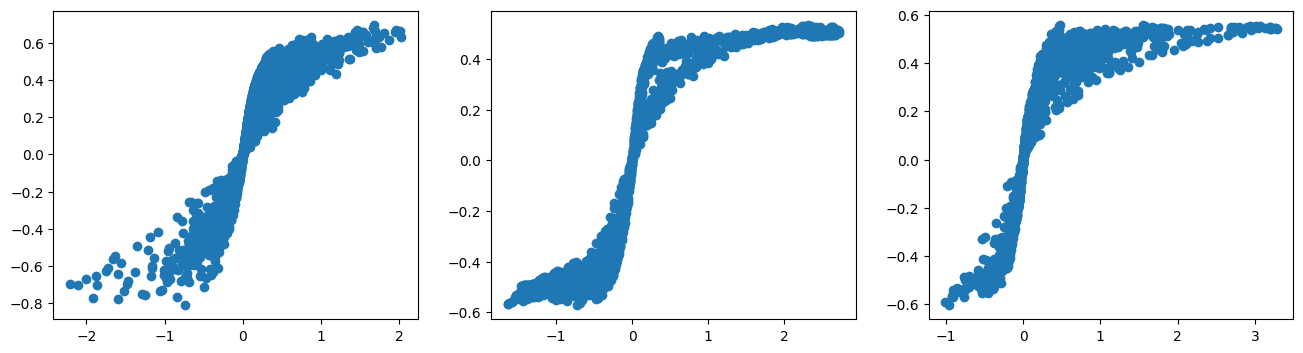

In [111]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))
for i, ax in enumerate(axes):
    ax.scatter(nn.max_pool(extras["intermediates"][prev_layer]["__call__"][0], window_shape=(2,2), strides=(2,2))[0,:,:,i].ravel(),
               extras["intermediates"][layer_name]["__call__"][0][0,:,:,i].ravel())
plt.show()

In [112]:
state.params["GDNGaussian_0"]

FrozenDict({
    GaussianLayerGamma_0: {
        A: array([1., 1., 1.], dtype=float32),
        bias: array([0.1, 0.1, 0.1], dtype=float32),
        gamma: array([25., 25., 25.], dtype=float32),
    },
})

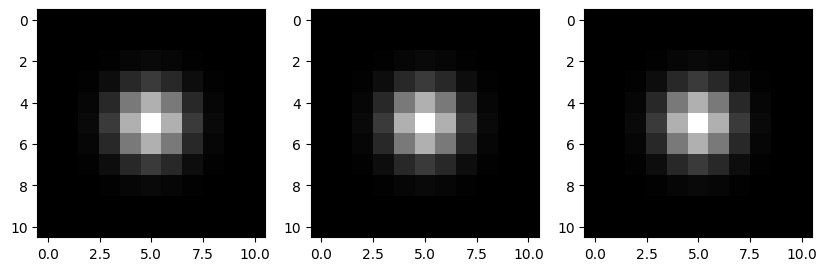

In [113]:
fig, axes = plt.subplots(1, 3, figsize=(10,10), squeeze=False)
m, M = state.state["precalc_filter"][layer_name]["GaussianLayerGamma_0"]["kernel"].min(), state.state["precalc_filter"][layer_name]["GaussianLayerGamma_0"]["kernel"].max()
k = 0
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        ax.imshow(state.state["precalc_filter"][layer_name]["GaussianLayerGamma_0"]["kernel"][:,:,i,j], vmin=m, vmax=M, cmap="gray")
        # ax.set_title(f'A: {state.params[layer_name]["A"][k]:.2f} | K: {state.params[layer_name]["K"][k]:.2f} | logS: {state.params[layer_name]["logsigma"][k]:.2f}')
        k += 1
plt.show()

In [114]:
state.state["precalc_filter"][layer_name]["GaussianLayerGamma_0"]["kernel"][:,:,0,0].sum(), state.state["precalc_filter"][layer_name]["GaussianLayerGamma_0"]["kernel"][:,:,0,1].sum(), state.state["precalc_filter"][layer_name]["GaussianLayerGamma_0"]["kernel"][:,:,0,2].sum()

(4.124961, 4.124961, 4.124961)

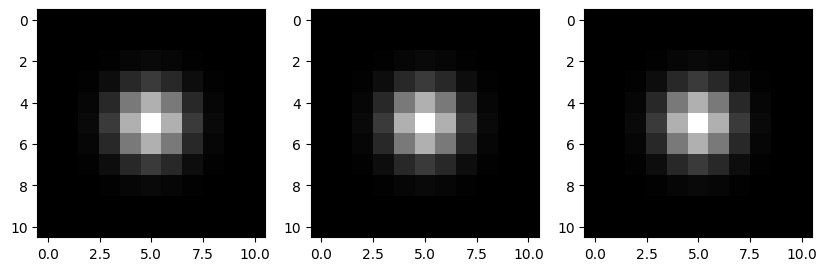

In [115]:
fig, axes = plt.subplots(1, 3, figsize=(10,10), squeeze=False)
m, M = state.state["precalc_filter"][layer_name]["GaussianLayerGamma_0"]["kernel"].min(), state.state["precalc_filter"][layer_name]["GaussianLayerGamma_0"]["kernel"].max()
k = 0
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        ax.imshow(state.state["precalc_filter"][layer_name]["GaussianLayerGamma_0"]["kernel"][:,:,i,j], cmap="gray")
        # ax.set_title(f'A: {state.params[layer_name]["A"][k]:.2f} | K: {state.params[layer_name]["K"][k]:.2f} | logS: {state.params[layer_name]["logsigma"][k]:.2f}')
        k += 1
plt.show()

### Gabor

In [140]:
prev_layer = "GDNGaussian_0"
layer_name = "GaborLayerGammaHumanLike__0"
# state.params[layer_name]

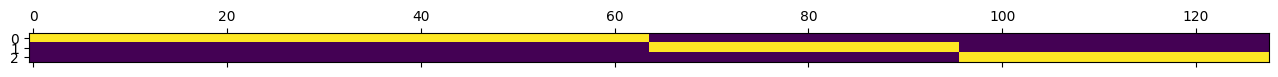

In [139]:
plt.matshow(state.params[layer_name]["A"])
plt.show()

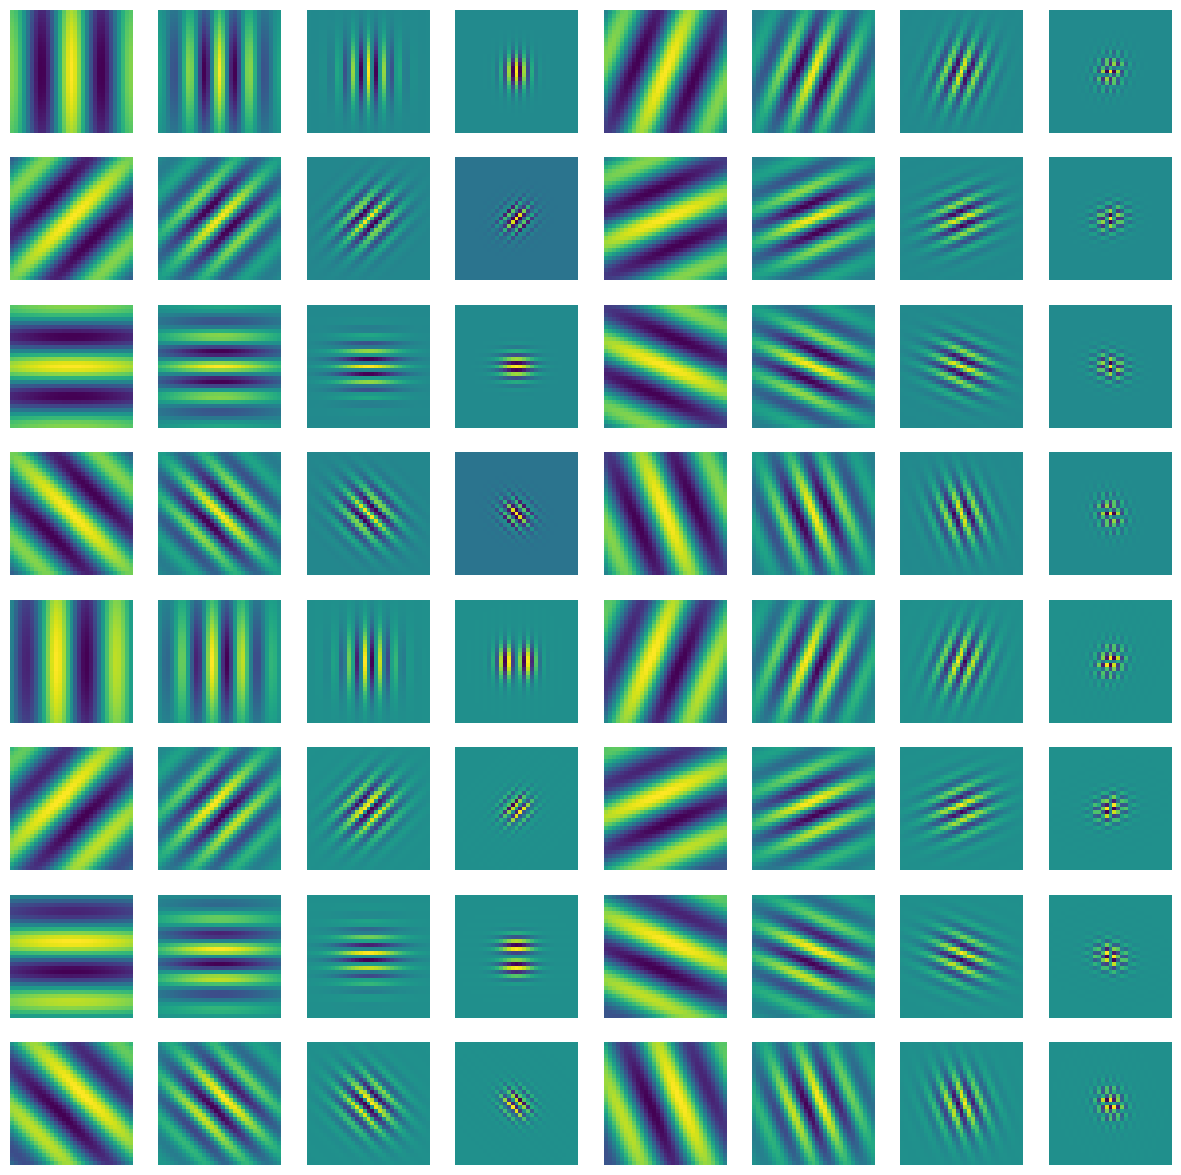

In [117]:
fig, axes = plt.subplots(8,8, figsize=(15,15))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(state.state["precalc_filter"][layer_name]["kernel"][:,:,0,i])
    ax.axis("off")
plt.show()

In [118]:
kernel = state.state["precalc_filter"][layer_name]["kernel"]
kernel.shape

(31, 31, 3, 128)

In [141]:
kernel_f_fft = jnp.fft.fftn(kernel[:,:,0,:], axes=(0,1))
kernel_f_fft = jnp.fft.fftshift(kernel_f_fft, axes=(0,1))
kernel_f_fft_abs_sum = jnp.abs(kernel_f_fft).sum(axis=-1)
kernel_f_fft.shape, kernel_f_fft_abs_sum.shape

((31, 31, 128), (31, 31))

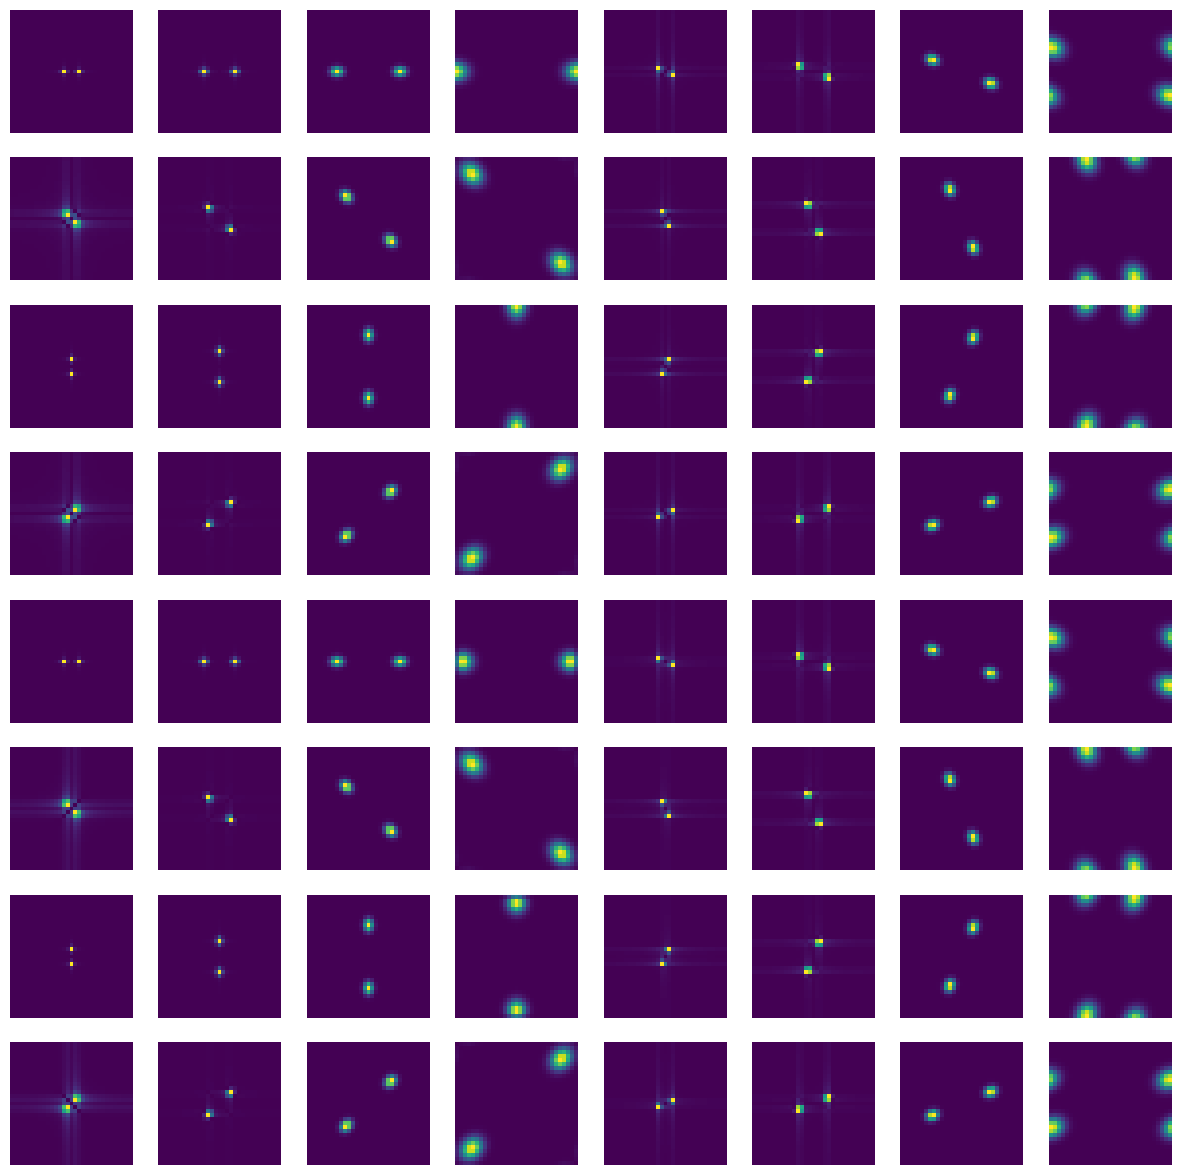

In [142]:
fig, axes = plt.subplots(8,8, figsize=(15,15))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(jnp.abs(kernel_f_fft[:,:,i]))
    ax.axis("off")
plt.show()

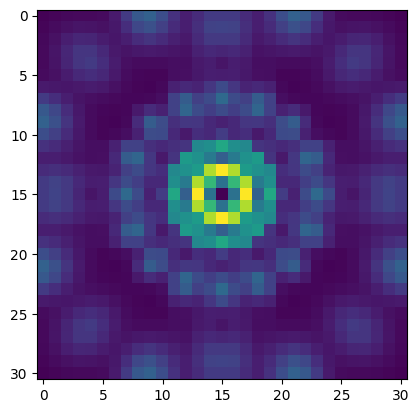

In [143]:
plt.imshow(kernel_f_fft_abs_sum)
plt.show()

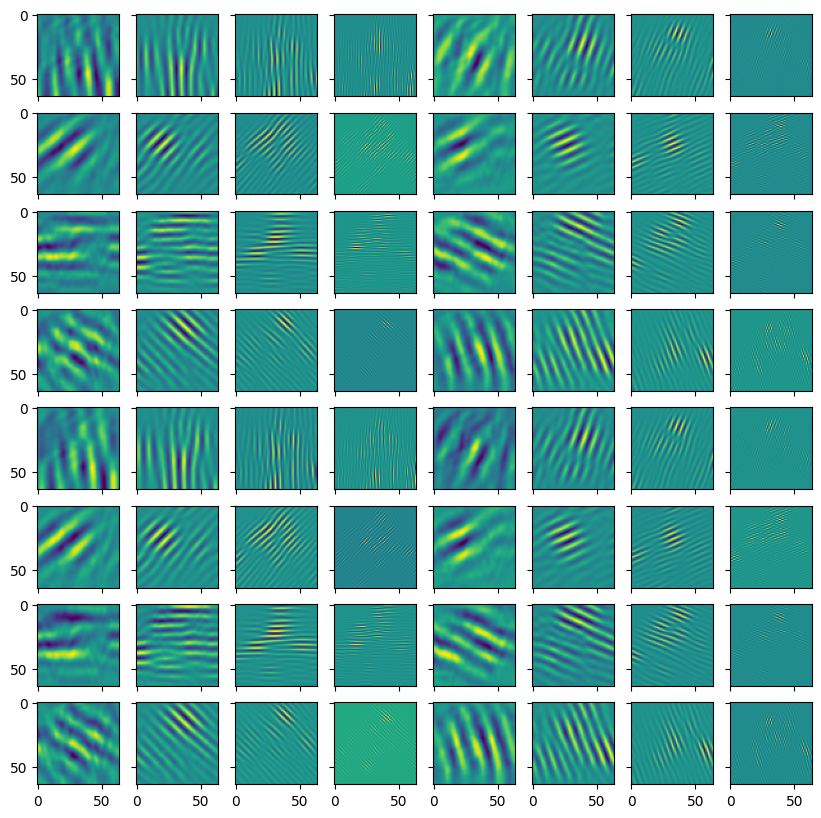

In [122]:
fig, axes = plt.subplots(8, 8, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    ax.imshow(extras["intermediates"][layer_name]["__call__"][0][0][0,:,:,i])
plt.show()
plt.show()

### DN (3)

In [145]:
prev_layer = "GaborLayerGammaHumanLike__0"
layer_name = "GDNSpatioChromaFreqOrient_0"
state.params[layer_name]

FrozenDict({
    ChromaFreqOrientGaussianGamma_0: {
        H_cc: array([[1., 0., 0.],
               [0., 1., 0.],
               [0., 0., 1.]], dtype=float32),
        gamma_f_a: array([1.25   , 0.625  , 0.3125 , 0.15625], dtype=float32),
        gamma_f_d: array([0.8333334, 0.4166667], dtype=float32),
        gamma_f_t: array([0.8333334, 0.4166667], dtype=float32),
        gamma_theta_a: array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05], dtype=float32),
        gamma_theta_d: array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05], dtype=float32),
        gamma_theta_t: array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05], dtype=float32),
    },
    GaussianLayerGamma_0: {
        A: array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
               1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
               1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
               1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

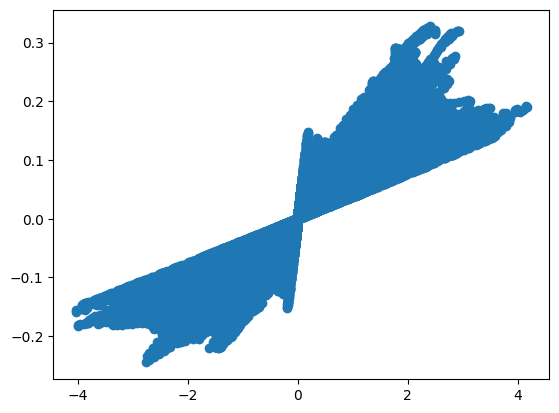

In [124]:
plt.scatter(extras["intermediates"][prev_layer]["__call__"][0][0].ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

In [125]:
extras["intermediates"][prev_layer]["__call__"][0][0].shape

(1, 64, 64, 128)

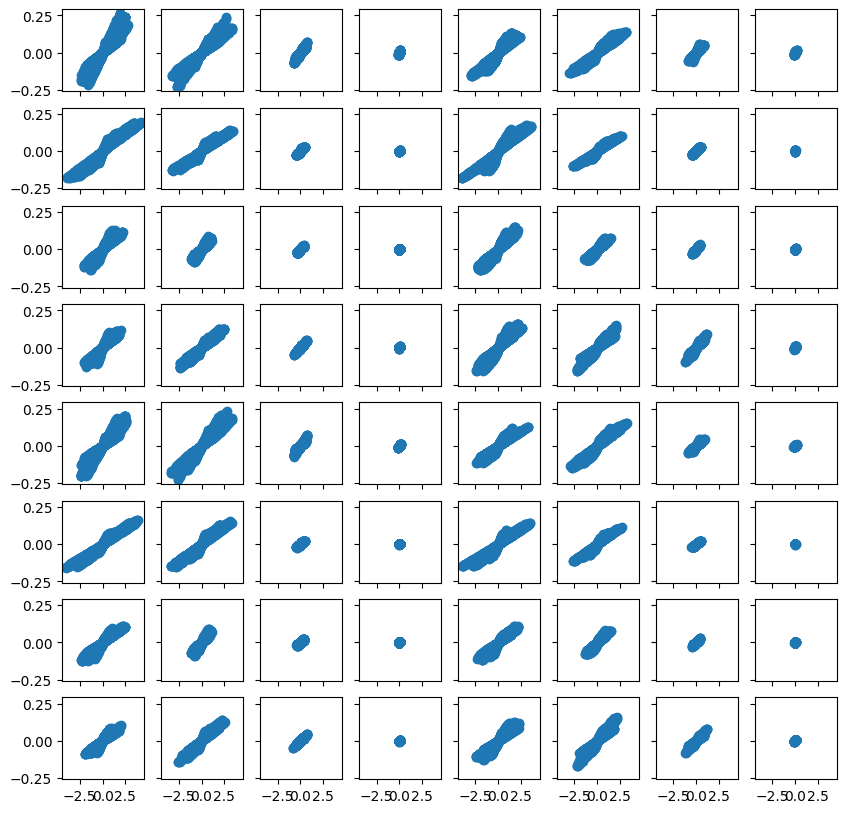

In [126]:
fig, axes = plt.subplots(8, 8, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    ax.scatter(extras["intermediates"][prev_layer]["__call__"][0][0][0,:,:,i].ravel(),
               extras["intermediates"][layer_name]["__call__"][0][0,:,:,i].ravel())
plt.show()
plt.show()

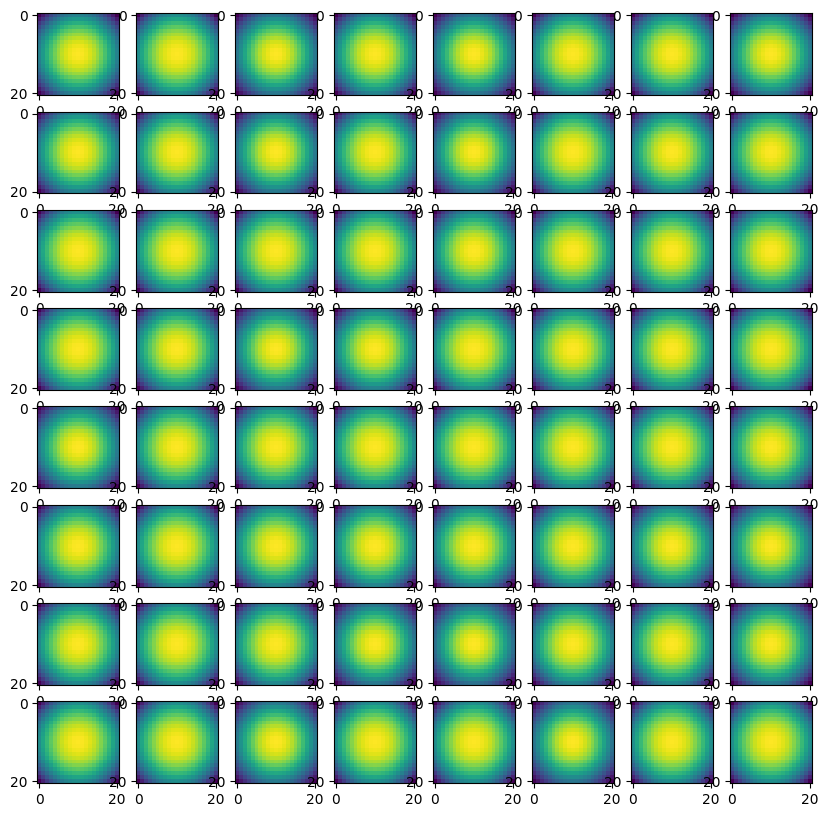

In [127]:
fig, axes = plt.subplots(8, 8, figsize=(10,10))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(state.state["precalc_filter"][layer_name]["GaussianLayerGamma_0"]["kernel"][:,:,0,i])
plt.show()

In [128]:
state.params[prev_layer]["freq_a"], state.params[prev_layer]["freq_t"], state.params[prev_layer]["freq_d"]

(array([ 2.,  4.,  8., 16.], dtype=float32),
 array([3., 6.], dtype=float32),
 array([3., 6.], dtype=float32))

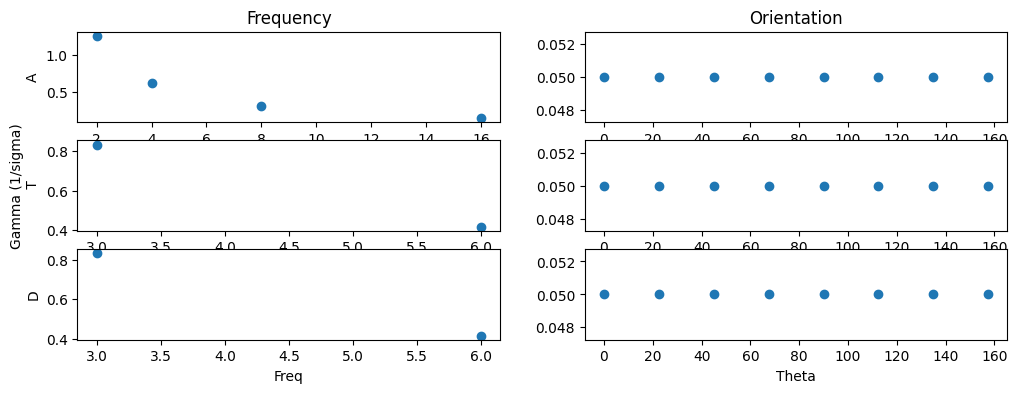

In [129]:
fig, axes = plt.subplots(3,2, figsize=(12,4))
axes[0,0].scatter(state.params[prev_layer]["freq_a"], state.params[layer_name]["ChromaFreqOrientGaussianGamma_0"]["gamma_f_a"])
axes[0,0].set_title("Frequency")
axes[0,0].set_ylabel("A")

axes[0,1].scatter(state.params[prev_layer]["theta_a"]*180/jnp.pi, state.params[layer_name]["ChromaFreqOrientGaussianGamma_0"]["gamma_theta_a"])
axes[0,1].set_title("Orientation")

axes[1,0].scatter(state.params[prev_layer]["freq_t"], state.params[layer_name]["ChromaFreqOrientGaussianGamma_0"]["gamma_f_t"])
axes[1,0].set_ylabel("Gamma (1/sigma)\n T")

axes[1,1].scatter(state.params[prev_layer]["theta_t"]*180/jnp.pi, state.params[layer_name]["ChromaFreqOrientGaussianGamma_0"]["gamma_theta_t"])

axes[2,0].scatter(state.params[prev_layer]["freq_d"], state.params[layer_name]["ChromaFreqOrientGaussianGamma_0"]["gamma_f_d"])
axes[2,0].set_xlabel("Freq")
axes[2,0].set_ylabel("D")

axes[2,1].scatter(state.params[prev_layer]["theta_d"]*180/jnp.pi, state.params[layer_name]["ChromaFreqOrientGaussianGamma_0"]["gamma_theta_d"])
axes[2,1].set_xlabel("Theta")

plt.show()

### Final output

In [130]:
state.params[layer_name]["ChromaFreqOrientGaussianGamma_0"]["H_cc"]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

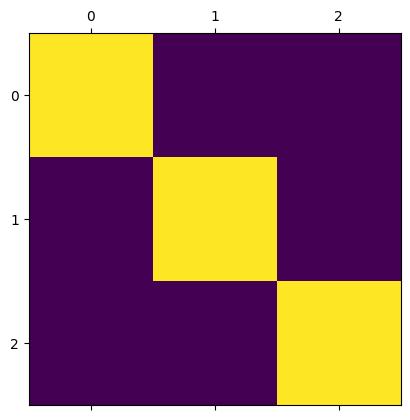

In [131]:
plt.matshow(state.params[layer_name]["ChromaFreqOrientGaussianGamma_0"]["H_cc"])
plt.show()

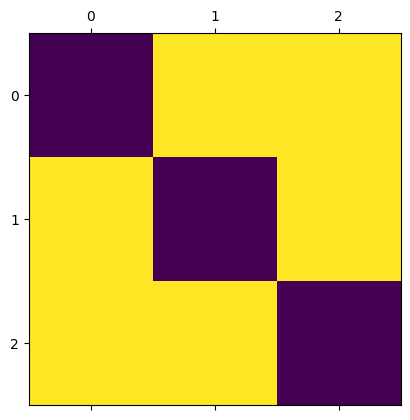

In [132]:
plt.matshow(1/(1e-5+state.params[layer_name]["ChromaFreqOrientGaussianGamma_0"]["H_cc"]))
plt.show()

(8, 16)


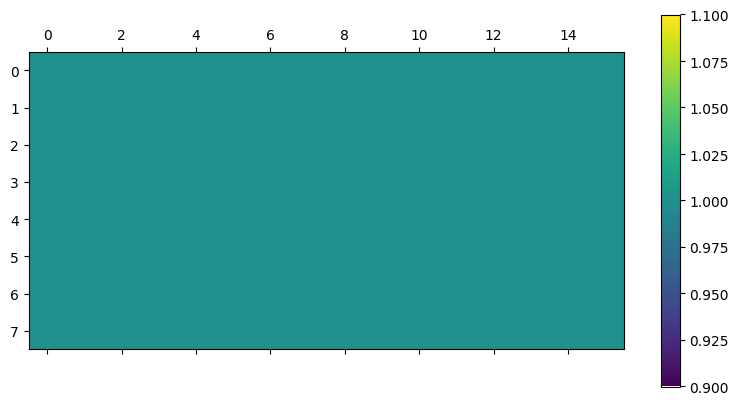

In [146]:
bias_m = rearrange(state.params[layer_name]["bias"], "(h w) -> h w", h=8, w=16)
print(bias_m.shape)
plt.matshow(bias_m)
plt.colorbar()
plt.show()

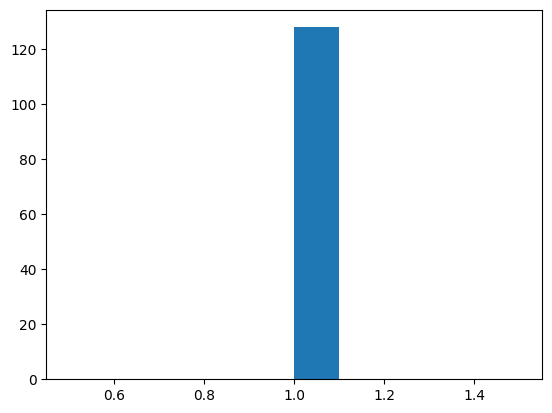

In [134]:
plt.hist(state.params[layer_name]["bias"])
plt.show()

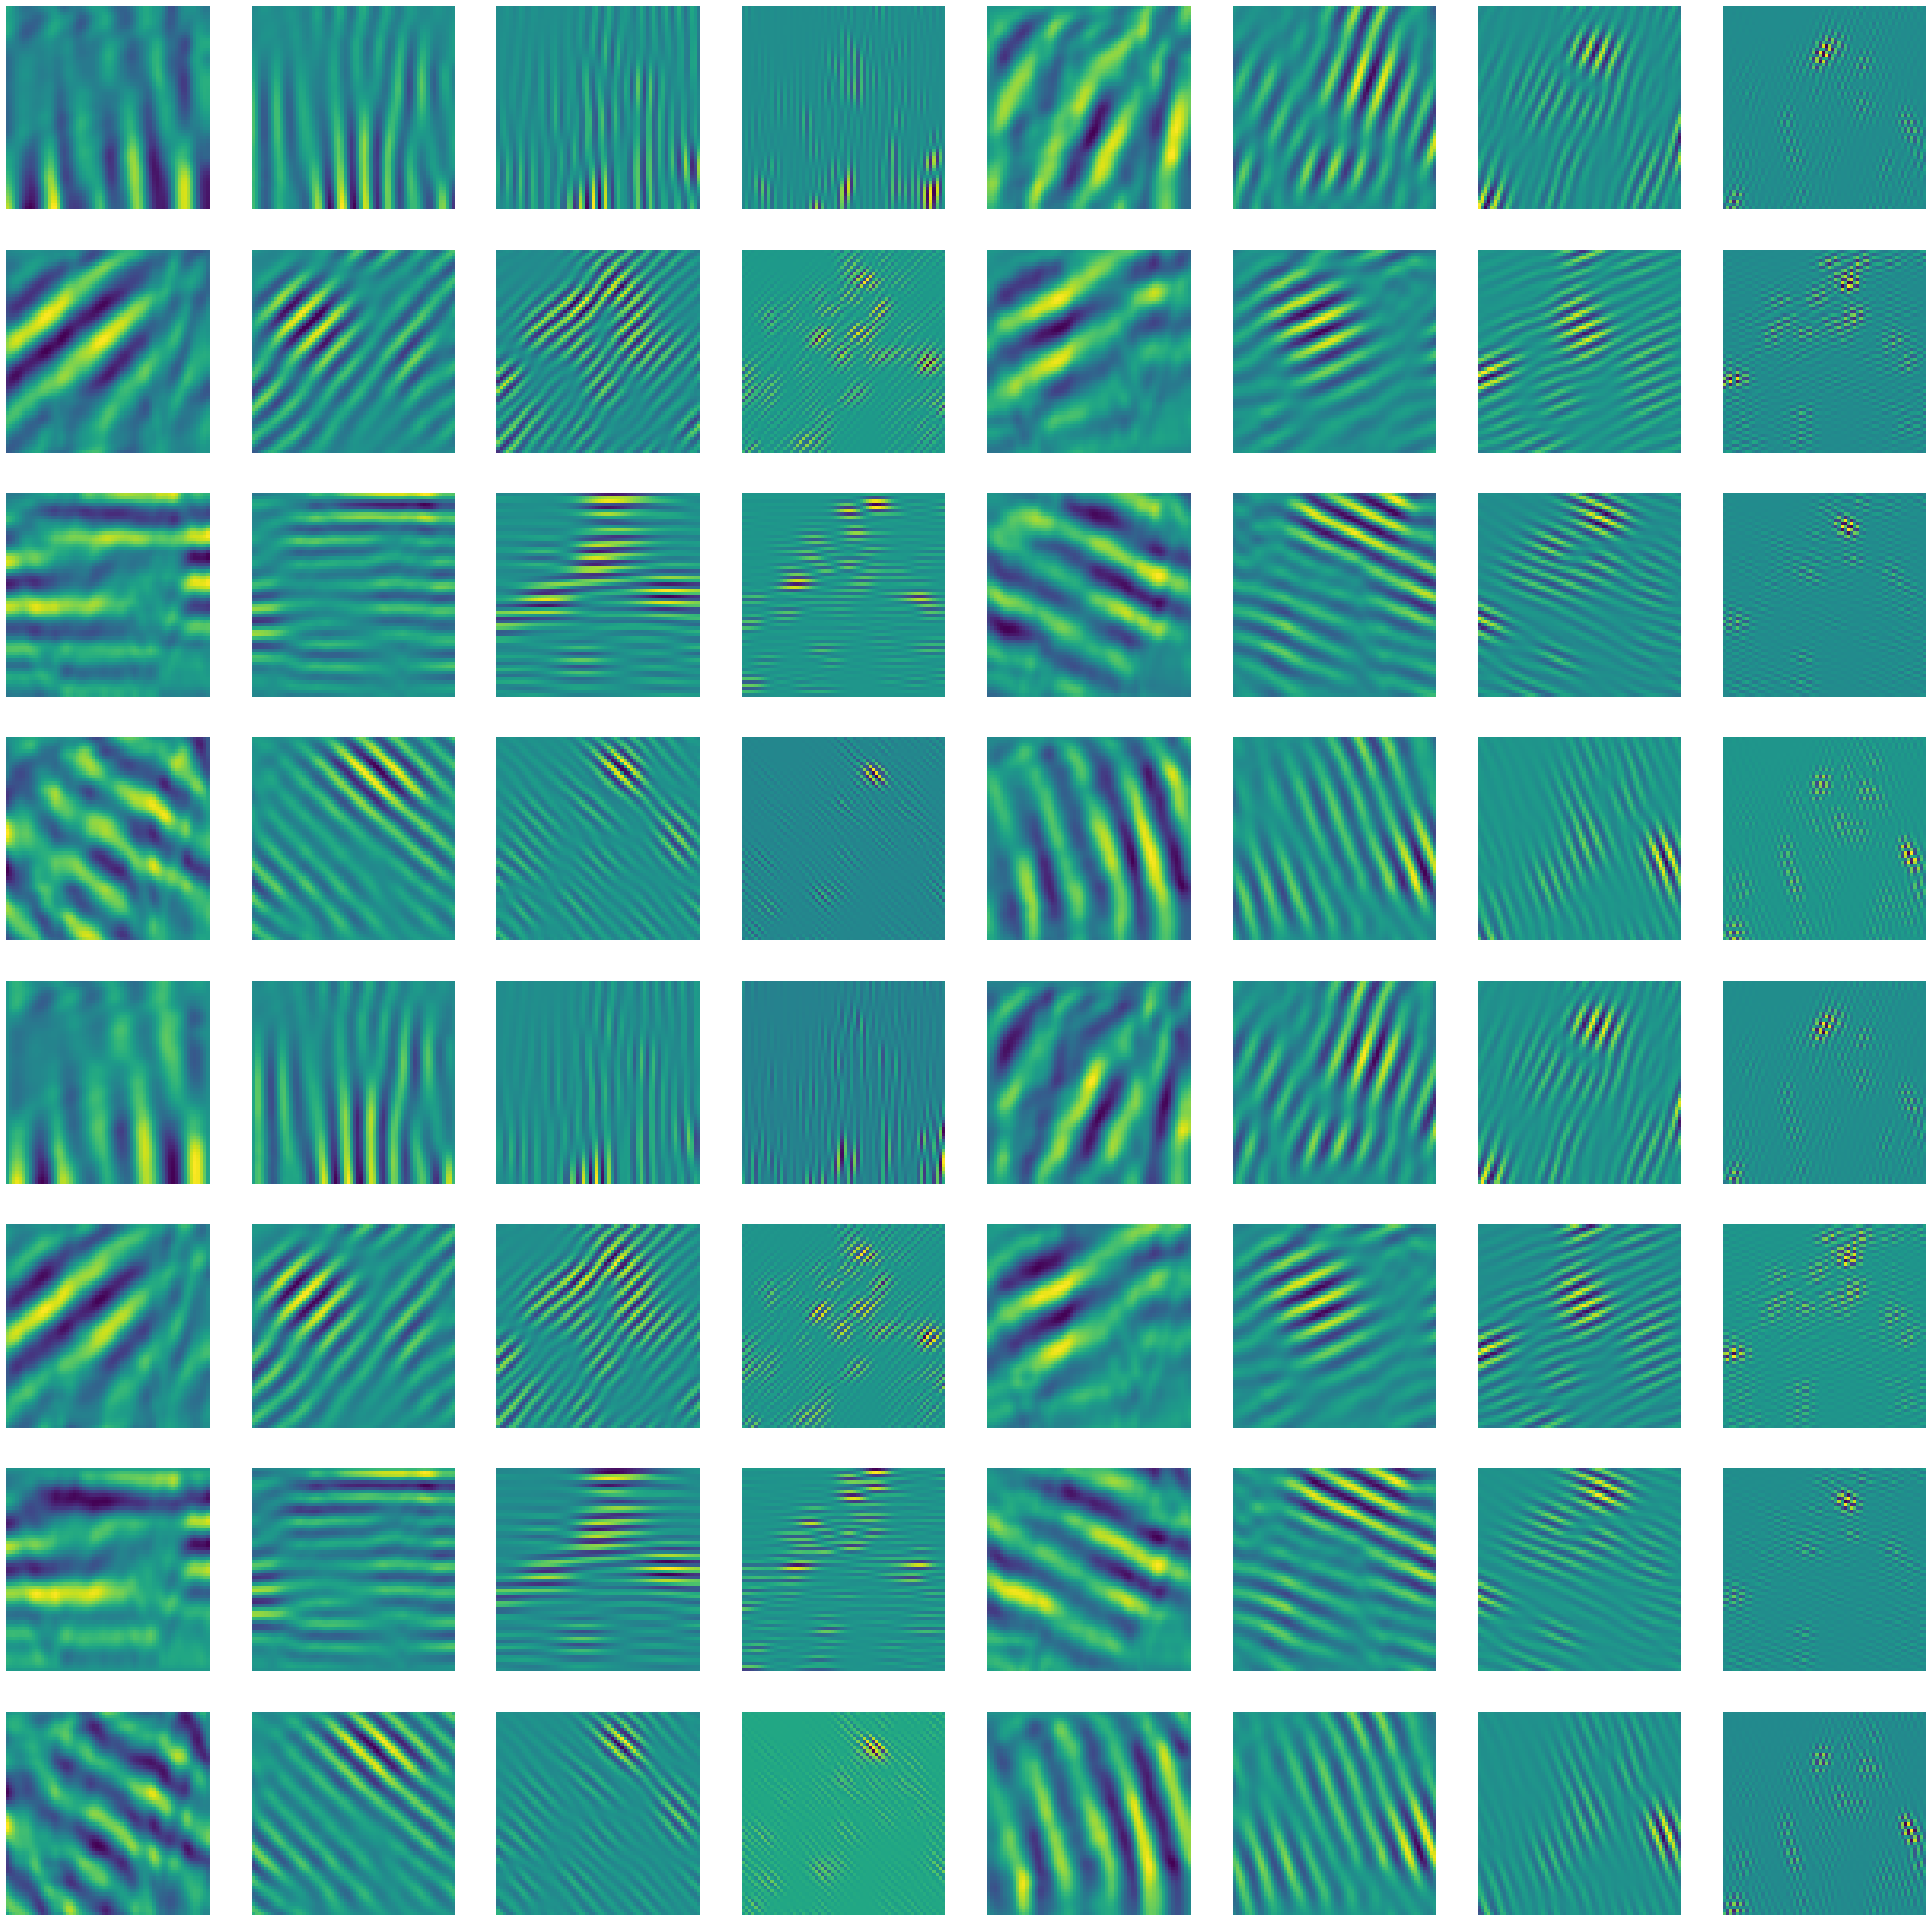

In [135]:
fig, axes = plt.subplots(8,8, figsize=(40,40))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(outputs[0,:,:,i])
    ax.axis("off")
plt.show()